In [3]:
import pandas as pd

# -----------------------------
# 1. LOAD BOTH DATASETS
# -----------------------------
station_month_df = pd.read_csv("station_month.csv")
station_df = pd.read_csv("stations.csv")

print("Noise columns BEFORE cleaning:", station_month_df.columns.tolist())
print("Metadata columns BEFORE cleaning:", station_df.columns.tolist())


Noise columns BEFORE cleaning: ['Station', 'Year', 'Month', 'Day', 'Night', 'DayLimit', 'NightLimit']
Metadata columns BEFORE cleaning: ['Station', 'Name', 'City', 'State', 'Type']


In [4]:
# Remove unnamed columns if any (safety)
station_month_df = station_month_df.loc[:, ~station_month_df.columns.str.contains('^Unnamed')]
station_df = station_df.loc[:, ~station_df.columns.str.contains('^Unnamed')]

# Strip whitespace
station_month_df.columns = station_month_df.columns.str.strip()
station_df.columns = station_df.columns.str.strip()

station_month_df['Station'] = station_month_df['Station'].astype(str).str.strip()
station_df['Station'] = station_df['Station'].astype(str).str.strip()

# Convert numeric columns
num_cols = ['Year', 'Month', 'Day', 'Night', 'DayLimit', 'NightLimit']
station_month_df[num_cols] = station_month_df[num_cols].apply(pd.to_numeric, errors='coerce')

# Merge both datasets
merged_df = pd.merge(station_month_df, station_df, on="Station", how="left")

# Display result
print("Merged dataset:")
print(merged_df)
print("\nShape:", merged_df.shape)


Merged dataset:
     Station  Year  Month   Day  Night  DayLimit  NightLimit Name       City  \
0      BEN01  2011      2  66.0   56.0        55          45  BTM  Bengaluru   
1      BEN01  2011      3  66.0   58.0        55          45  BTM  Bengaluru   
2      BEN01  2011      4  66.0   57.0        55          45  BTM  Bengaluru   
3      BEN01  2011      5  66.0   56.0        55          45  BTM  Bengaluru   
4      BEN01  2011      6  67.0   57.0        55          45  BTM  Bengaluru   
...      ...   ...    ...   ...    ...       ...         ...  ...        ...   
5000   MUM10  2018      8  73.0   69.0        65          55  CST     Mumbai   
5001   MUM10  2018      9  72.0   68.0        65          55  CST     Mumbai   
5002   MUM10  2018     10  73.0   68.0        65          55  CST     Mumbai   
5003   MUM10  2018     11  72.0   68.0        65          55  CST     Mumbai   
5004   MUM10  2018     12  72.0   68.0        65          55  CST     Mumbai   

            State      

In [5]:
import numpy as np

df = merged_df.copy()

# 1. Day Excess (how much above legal limit)
df['Day_Excess'] = df['Day'] - df['DayLimit']

# 2. Night Excess
df['Night_Excess'] = df['Night'] - df['NightLimit']

# 3. Total Exceedance
df['Total_Exceedance'] = df['Day_Excess'] + df['Night_Excess']

# 4. Noise Index (overall loudness)
df['Noise_Index'] = (df['Day'] + df['Night']) / 2

# 5. Difference between Day and Night
df['DayNight_Diff'] = df['Day'] - df['Night']

# 6. Season Feature
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Summer"
    elif month in [6, 7, 8]:
        return "Monsoon"
    else:
        return "Festive"

df['Season'] = df['Month'].apply(get_season)

# 7. Encode Season as numeric
df['Season_Code'] = df['Season'].map({
    'Winter': 0,
    'Summer': 1,
    'Monsoon': 2,
    'Festive': 3
})

# Show new dataset
df.head(), df.tail()


(  Station  Year  Month   Day  Night  DayLimit  NightLimit Name       City  \
 0   BEN01  2011      2  66.0   56.0        55          45  BTM  Bengaluru   
 1   BEN01  2011      3  66.0   58.0        55          45  BTM  Bengaluru   
 2   BEN01  2011      4  66.0   57.0        55          45  BTM  Bengaluru   
 3   BEN01  2011      5  66.0   56.0        55          45  BTM  Bengaluru   
 4   BEN01  2011      6  67.0   57.0        55          45  BTM  Bengaluru   
 
        State         Type  Day_Excess  Night_Excess  Total_Exceedance  \
 0  Karnataka  Residential        11.0          11.0              22.0   
 1  Karnataka  Residential        11.0          13.0              24.0   
 2  Karnataka  Residential        11.0          12.0              23.0   
 3  Karnataka  Residential        11.0          11.0              22.0   
 4  Karnataka  Residential        12.0          12.0              24.0   
 
    Noise_Index  DayNight_Diff   Season  Season_Code  
 0         61.0           10.

In [6]:
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = [
    'Day',
    'Night',
    'Day_Excess',
    'Night_Excess',
    'Total_Exceedance',
    'Noise_Index',
    'DayNight_Diff'
]

X = df[features]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]  # Show first 5 scaled rows


array([[ 0.02467699, -0.54220245,  0.60808405,  0.18706577,  0.3879791 ,
        -0.28187236,  1.19907367],
       [ 0.02467699, -0.29746169,  0.60808405,  0.36415162,  0.48480669,
        -0.1495833 ,  0.67775998],
       [ 0.02467699, -0.41983207,  0.60808405,  0.27560869,  0.43639289,
        -0.21572783,  0.93841682],
       [ 0.02467699, -0.54220245,  0.60808405,  0.18706577,  0.3879791 ,
        -0.28187236,  1.19907367],
       [ 0.15957787, -0.41983207,  0.71105075,  0.27560869,  0.48480669,
        -0.1495833 ,  1.19907367]])

In [7]:
df[features].isnull().sum()



,0
Day,3
Night,10
Day_Excess,3
Night_Excess,10
Total_Exceedance,10
Noise_Index,10
DayNight_Diff,10


In [8]:
df = df.dropna(subset=features)
df.shape


(4995, 18)

In [9]:
df[features].isnull().sum()


,0
Day,0
Night,0
Day_Excess,0
Night_Excess,0
Total_Exceedance,0
Noise_Index,0
DayNight_Diff,0


In [10]:
from sklearn.preprocessing import StandardScaler

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


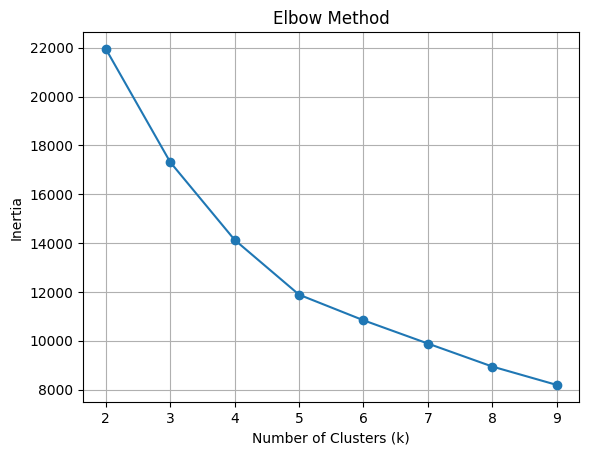

In [11]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []

for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2, 10), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()


In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

df[['Station','City','Type','Noise_Index','Total_Exceedance','Cluster']].head(20)


,Station,City,Type,Noise_Index,Total_Exceedance,Cluster
0,BEN01,Bengaluru,Residential,61.0,22.0,0
1,BEN01,Bengaluru,Residential,62.0,24.0,0
2,BEN01,Bengaluru,Residential,61.5,23.0,0
3,BEN01,Bengaluru,Residential,61.0,22.0,0
4,BEN01,Bengaluru,Residential,62.0,24.0,0
5,BEN01,Bengaluru,Residential,62.0,24.0,0
6,BEN01,Bengaluru,Residential,63.0,26.0,0
7,BEN01,Bengaluru,Residential,61.0,22.0,0
8,BEN01,Bengaluru,Residential,61.0,22.0,0
9,BEN01,Bengaluru,Residential,61.0,22.0,0


In [13]:
cluster_summary = df.groupby('Cluster')[features].mean()
cluster_summary


,Day,Night,Day_Excess,Night_Excess,Total_Exceedance,Noise_Index,DayNight_Diff
Cluster,,,,,,,
0,69.341282,62.885246,8.489319,11.625931,20.115251,66.113264,6.456036
1,62.382184,57.370690,-11.468391,-10.926724,-22.395115,59.876437,5.011494
2,59.072428,53.381010,3.433354,7.741935,11.175289,56.226719,5.691418
3,75.841369,74.073095,16.673406,24.687403,41.360809,74.957232,1.768274


In [14]:
zone_labels = {
    1: "Silent Zone",
    2: "Moderate Noise Zone",
    0: "High Noise Zone",
    3: "Danger Zone"
}

df['Noise_Zone'] = df['Cluster'].map(zone_labels)



In [15]:
df[['Station','City','Cluster','Noise_Zone']]

,Station,City,Cluster,Noise_Zone
0,BEN01,Bengaluru,0,High Noise Zone
1,BEN01,Bengaluru,0,High Noise Zone
2,BEN01,Bengaluru,0,High Noise Zone
3,BEN01,Bengaluru,0,High Noise Zone
4,BEN01,Bengaluru,0,High Noise Zone
...,...,...,...,...
5000,MUM10,Mumbai,0,High Noise Zone
5001,MUM10,Mumbai,0,High Noise Zone
5002,MUM10,Mumbai,0,High Noise Zone
5003,MUM10,Mumbai,0,High Noise Zone


In [16]:
city_zone_counts = df.groupby(['City', 'Noise_Zone']).size().unstack().fillna(0)
city_zone_counts


Noise_Zone,Danger Zone,High Noise Zone,Moderate Noise Zone,Silent Zone
City,,,,
Bengaluru,30.0,229.0,285.0,171.0
Chennai,126.0,507.0,78.0,4.0
Delhi,67.0,137.0,506.0,2.0
Hyderabad,126.0,242.0,214.0,133.0
Kolkata,143.0,248.0,216.0,102.0
Lucknow,40.0,296.0,235.0,144.0
Mumbai,79.0,291.0,109.0,140.0
Navi Mumbai,32.0,63.0,0.0,0.0


In [17]:
type_zone_counts = df.groupby(['Type', 'Noise_Zone']).size().unstack().fillna(0)
type_zone_counts


Noise_Zone,Danger Zone,High Noise Zone,Moderate Noise Zone,Silent Zone
Type,,,,
Commercial,293.0,1075.0,463.0,75.0
Industrial,28.0,164.0,0.0,619.0
Residential,160.0,324.0,464.0,0.0
Silence,162.0,450.0,716.0,2.0


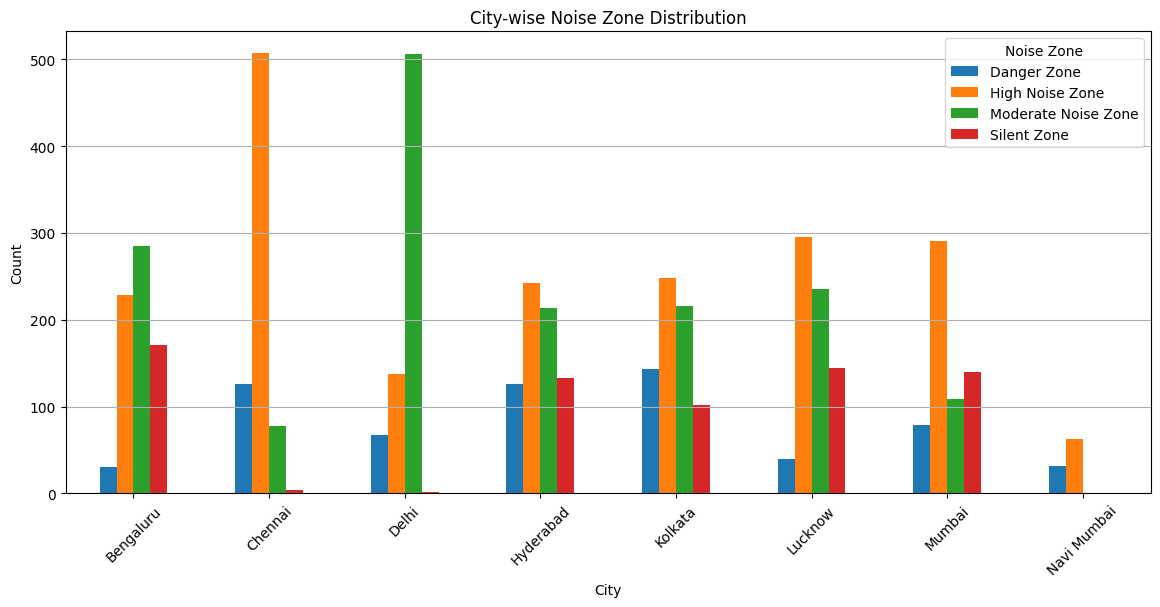

In [18]:
import matplotlib.pyplot as plt

city_zone_counts.plot(kind='bar', figsize=(14,6))
plt.title("City-wise Noise Zone Distribution")
plt.xlabel("City")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Noise Zone")
plt.grid(axis='y')
plt.show()


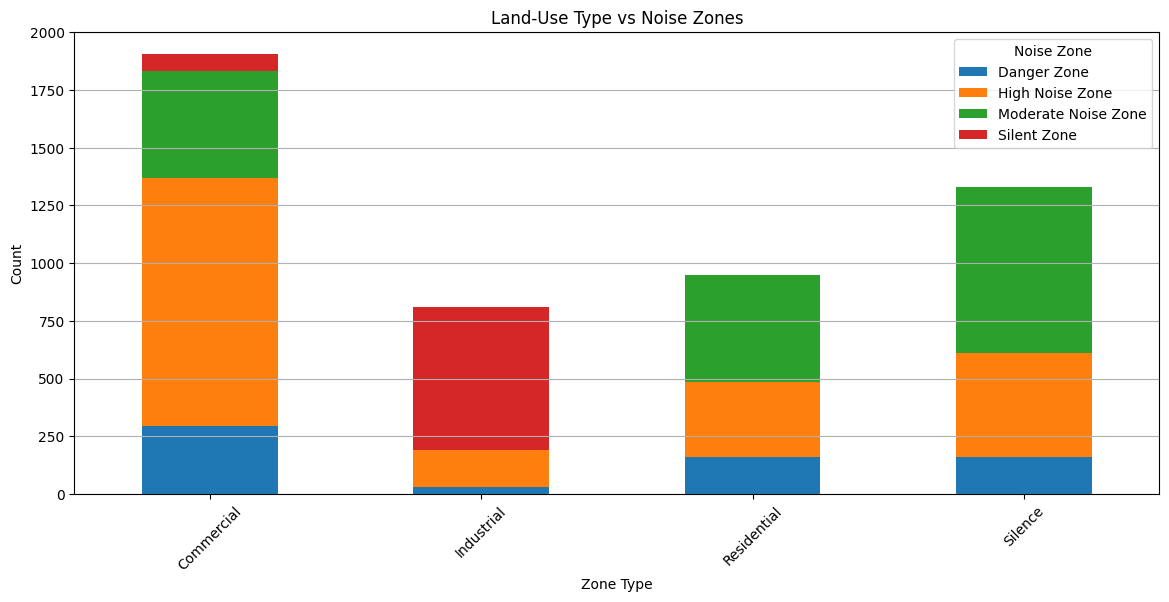

In [19]:
type_zone_counts.plot(kind='bar', stacked=True, figsize=(14,6))
plt.title("Land-Use Type vs Noise Zones")
plt.xlabel("Zone Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Noise Zone")
plt.grid(axis='y')
plt.show()


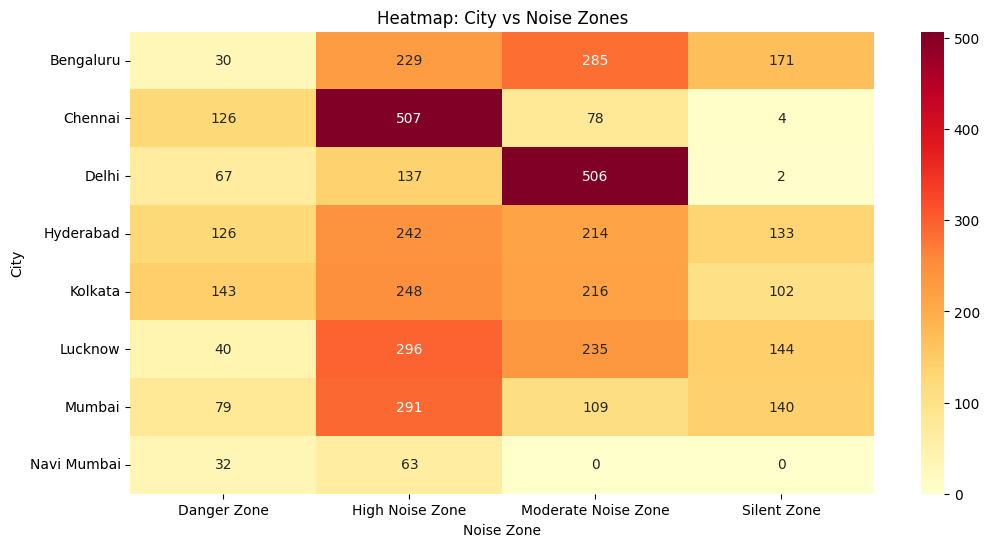

In [20]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.heatmap(city_zone_counts, annot=True, fmt=".0f", cmap="YlOrRd")
plt.title("Heatmap: City vs Noise Zones")
plt.xlabel("Noise Zone")
plt.ylabel("City")
plt.show()


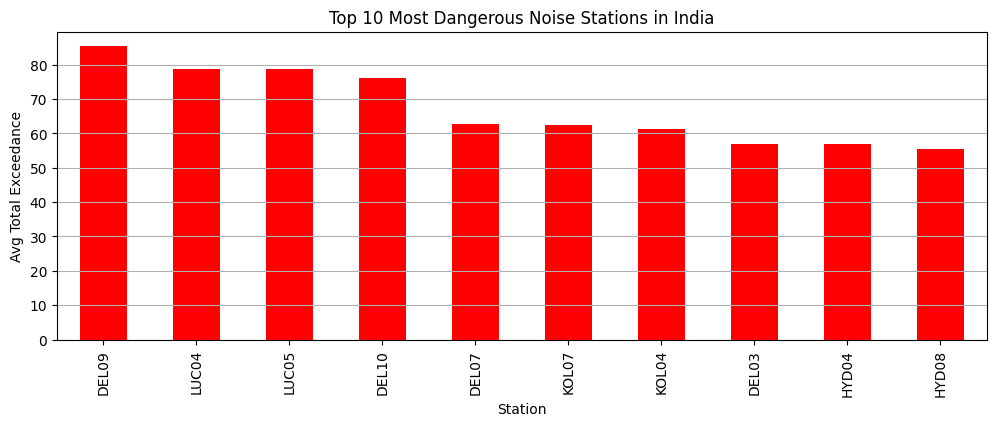

In [21]:
danger_stations = df[df['Noise_Zone'] == 'Danger Zone']
danger_rank = danger_stations.groupby('Station')['Total_Exceedance'] \
                             .mean() \
                             .sort_values(ascending=False) \
                             .head(10)

danger_rank.plot(kind='bar', figsize=(12,4), color='red')
plt.title("Top 10 Most Dangerous Noise Stations in India")
plt.xlabel("Station")
plt.ylabel("Avg Total Exceedance")
plt.grid(axis='y')
plt.show()
